# 라이브러리 불러오기

In [1]:
import pandas as pd
import os
import numpy as np
import win32com.client as win32
from sklearn.preprocessing import MinMaxScaler
pd.set_option('mode.chained_assignment',  None)
from functools import reduce

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples
import matplotlib as mpl
import seaborn as sns
from datetime import timedelta
from datetime import datetime
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D



%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.family']='Malgun Gothic'
mpl.rcParams['axes.unicode_minus']=False

# TAAS에 제공되는 XLS파일 XLSX파일로 변환

In [2]:
year=['2020','2021']
for q in year:
    filename1= os.listdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표xls파일\\{q}')
    for i in filename1:
        for w in range(len(os.listdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표xls파일\\{q}/{i}'))):
            filename2=os.listdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표xls파일\\{q}/{i}') 
            if filename2[w][-3:]=='xls':
                fname = f"C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표xls파일\\{q}\\{i}\\{i}_{filename2[w][-6:-4]}.xls"
                excel = win32.gencache.EnsureDispatch('Excel.Application')
                wb = excel.Workbooks.Open(fname)
                fname=f"C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표xlsx파일\\{q}\\{i}\\{i}_{filename2[w][-6:-4]}.xls"
                wb.SaveAs(fname+"x", FileFormat = 51) #FileFormat = 51 is for .xlsx extension
                wb.Close() #FileFormat = 56 is for .xls extension
                excel.Application.Quit()
            else:
                continue

# 최종세부지표(행정동 : 사망자수, 중상자수, 경상자수, 부상신고자수)

In [3]:
year=['2017','2018','2019']
for q in year:
    os.chdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표완료\\{q}')
    filename3=os.listdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표xlsx파일\\{q}') 
    data=pd.read_csv(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\사고데이터 행정동변환\\{q}최종.csv')
    for i in filename3:
        os.chdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표완료\\{q}\\{i}')
        for w in range(len(os.listdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표xlsx파일\\{q}/{i}'))):
            filename4=os.listdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표xlsx파일\\{q}/{i}') 
            if filename4[w][-4:]=='xlsx':
                acc=pd.read_excel(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표xlsx파일\\{q}\\{i}\\{i}_{filename4[w][-7:-5]}.xlsx')
                acc['사고건수']=1
                total=pd.merge(acc,data,how='left',on=list(acc[acc.columns.difference(['사고번호', '행정동','사고건수','피해운전자 차종',
                                                                                  '피해운전자 성별','피해운전자 연령','피해운전자 상해정도'])].columns))  
                total=total[['행정동','사고건수','사망자수','중상자수','경상자수','부상신고자수']]
                total=total.groupby('행정동').sum()
                total.to_csv(f'{i}_{filename4[w][-7:-5]}_{q}.csv',encoding='utf-8-sig')
            else:
                continue

# 도로연장 구하기

In [4]:
word_list=os.listdir(r'C:\Users\User\Desktop\천안10.14\v0.2_읍면동 qgis\도로연장')
search='.xlsx'
word_list = [word.strip(search) for word in word_list ] 
acc=pd.DataFrame()
for j in word_list:
    data=pd.read_excel(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.2_읍면동 qgis\\도로연장\\{j}.xlsx')
    data['행정동']=j
    data['도로연장']=data['length'].sum()
    data=data.drop(['id','length'],axis=1)
    data=data.drop_duplicates()
    acc=pd.concat([acc,data])
os.chdir(r'C:\Users\User\Desktop\천안10.14\v0.2_읍면동 qgis\행정동별 도로연장 및 지역계수')    
acc.to_csv('행정동별_도로연장.csv',encoding='utf-8-sig',index=False)    

person=pd.read_excel(r'C:\Users\User\Desktop\천안10.14\v0.2_읍면동 qgis\행정동별 도로연장 및 지역계수\연도별 인구수.xlsx')
total=pd.merge(acc,person,how='left',on='행정동')
total=total.set_index('행정동')
total['2020지역계수']=np.sqrt(total['2020인구수']*total['도로연장'])
total['2021지역계수']=np.sqrt(total['2021인구수']*total['도로연장'])
total.to_csv('행정동별_도로연장(인구 및 지역계수 추가).csv',encoding='utf-8-sig')

# 세부지표점수

In [5]:
year=['2020','2021']
for q in year:
    filename=os.listdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표완료\\{q}')
    os.chdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표점수\\{q}')
    for i in filename:
        acc_total=pd.DataFrame()
        for w in range(len(os.listdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표완료\\{q}\\{i}'))):
            filename2=os.listdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표완료\\{q}\\{i}') 
            acc=pd.read_csv(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표완료\\{q}\\{i}\\{filename2[w][:-4]}.csv')
            if filename2[w][-11:-9]=='사망':
                acc['사상자수']=acc['사망자수']*1+acc['중상자수']*(28.8/198)+acc['경상자수']*(2/198)+acc['부상신고자수']*(1/198)
            elif filename2[w][-11:-9]=='중상':
                acc['사상자수']=acc['중상자수']*1+acc['경상자수']*(2.1/29.9)+acc['부상신고자수']*(1/29.9)
            elif filename2[w][-11:-9]=='경상':
                acc['사상자수']=acc['경상자수']*1+acc['부상신고자수']*(1/2.1)
            else:
                acc['사상자수']=acc['부상신고자수']*1
                
            acc['사고 및 사상자수']=acc['사고건수']*acc['사상자수']
            acc=pd.merge(total,acc,how='left',on='행정동')
            acc['사고 및 사상자수']=acc['사고 및 사상자수'].replace(np.NaN,0)
            acc['지표점수']=acc['사고 및 사상자수']/acc[f'{q}지역계수']
            acc=acc[['행정동','지표점수']]
            acc=acc.set_index('행정동')
            acc[f'{filename2[w][:-4]}Z-score']= (acc['지표점수'] - acc['지표점수'].mean(axis=0)) /acc['지표점수'].std(axis=0)
            acc=acc.drop('지표점수',axis=1)
            acc=(acc-(-2.0))/(7.5-(-2.0))# 최대-최소 정규화
            if acc.columns[0][-14:-12]=='사망':
                acc[f'{filename2[w][:-4]}Z-score']=acc[f'{filename2[w][:-4]}Z-score']*0.6
            elif acc.columns[0][-14:-12]=='중상':
                acc[f'{filename2[w][:-4]}Z-score']=acc[f'{filename2[w][:-4]}Z-score']*0.2
            elif acc.columns[0][-14:-12]=='경상':
                acc[f'{filename2[w][:-4]}Z-score']=acc[f'{filename2[w][:-4]}Z-score']*0.15
            elif acc.columns[0][-14:-12]=='부상':        
                acc[f'{filename2[w][:-4]}Z-score']=acc[f'{filename2[w][:-4]}Z-score']*0.05
            else:
                continue

            acc_total=pd.concat([acc_total,acc])
        acc_total=acc_total.groupby('행정동').sum()
        acc_total=pd.DataFrame(acc_total.sum(axis=1))
        acc_total=acc_total.rename(columns={0:f'{filename2[w][:-12]}'})
        acc_total.to_csv(f'{i}세부지표점수.csv',encoding='utf-8-sig')

# 백분위 세부지표점수 구하기

In [6]:
file=os.listdir(r'C:\Users\User\Desktop\천안10.14\v0.1_사고\세부지표점수')
year=['2020','2021']
for q in year:
    file=os.listdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\세부지표점수\\{q}')
    os.chdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\백분위세부지표점수\\{q}')
    for i in file:
        data=pd.read_csv(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표점수\\{q}\\{i}')
        data=data.set_index('행정동')
        data[f'{data.columns[0]}_세부지표점수']=(1-data[data.columns[0]])*100
        data=data.drop(f'{data.columns[0]}',axis=1)
        data.to_csv(f'{i}',encoding='utf-8-sig')

# 연도별 최종교통안전지수 산출

In [7]:
year=['2020','2021']
for q in year:
    car=pd.DataFrame(data.index,columns=['행정동'])
    car=car.astype({'행정동':'object'})
    bike=pd.DataFrame(data.index,columns=['행정동'])
    bike=bike.astype({'행정동':'object'})
    per=pd.DataFrame(data.index,columns=['행정동'])
    per=per.astype({'행정동':'object'})
    baby=pd.DataFrame(data.index,columns=['행정동'])
    baby=baby.astype({'행정동':'object'})
    traffic=pd.DataFrame(data.index,columns=['행정동'])
    traffic=traffic.astype({'행정동':'object'})
    road=pd.DataFrame(data.index,columns=['행정동'])
    road=road.astype({'행정동':'object'})
    for i in os.listdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\세부지표완료\\{q}'):
            os.chdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\백분위세부지표점수\\{q}')
            data=pd.read_csv(f'{i}세부지표점수.csv')
            if (i[:2]=='버스' or i[:2]=='택시'or i[:2]=='화물'or i[:2]=='렌터'):
                car=pd.merge(car,data,how='left',on='행정동')
                car=car.set_index('행정동')


            elif (i[:2]=='자전' or i[:2]=='이륜'):
                bike=pd.merge(bike,data,how='left',on='행정동')
                bike=bike.set_index('행정동')


            elif (i[:2]=='횡단' or i[:2]=='차도' or i[:2]=='길가' or i[:2]=='보도'):
                per=pd.merge(per,data,how='left',on='행정동')
                per=per.set_index('행정동')


            elif (i[:2]=='어린' or i[:2]=='노인'):
                baby=pd.merge(baby,data,how='left',on='행정동')    
                baby=baby.set_index('행정동')


            elif (i[:2]=='과속' or i[:2]=='신호' or i[:2]=='음주' or i[:2]=='중앙'):
                traffic=pd.merge(traffic,data,how='left',on='행정동')  
                traffic=traffic.set_index('행정동')

            else:
                road=pd.merge(road,data,how='left',on='행정동')
                road=road.set_index('행정동')


    os.chdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\영역별 점수\\{q}') 
    car['사업용자동차']=car.mean(axis=1)
    car=car.loc[:, car.columns == '사업용자동차']
    bike['자전거및이륜차']=bike.mean(axis='columns')
    bike=bike.loc[:, bike.columns == '자전거및이륜차']
    per['보행자']=per.mean(axis='columns')
    per=per.loc[:, per.columns == '보행자']  
    baby['교통약자']=baby.mean(axis='columns')
    baby=baby.loc[:, baby.columns == '교통약자']
    traffic['운전자']=traffic.mean(axis='columns')
    traffic=traffic.loc[:, traffic.columns == '운전자']              
    road['도로환경']=road.mean(axis='columns')
    road=road.loc[:, road.columns == '도로환경']  
    os.chdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\영역별 점수\\{q}')            
    car.to_csv('사업용자동차.csv',encoding='utf-8-sig')
    bike.to_csv('자전거및이륜차.csv',encoding='utf-8-sig')
    per.to_csv('보행자.csv',encoding='utf-8-sig')
    baby.to_csv('교통약자.csv',encoding='utf-8-sig')
    traffic.to_csv('운전자.csv',encoding='utf-8-sig')
    road.to_csv('도로환경.csv',encoding='utf-8-sig')
    dfs = [car,bike,per,baby,traffic,road]
    data = reduce(lambda a, b: pd.merge(a, b, how='left',on='행정동'), dfs)
    data['최종교통안전지수']=data.mean(axis=1)
    os.chdir(f'C:\\Users\\User\\Desktop\\천안10.14\\v0.1_사고\\최종교통안전지수\\{q}') 
    data=data.sort_values(by='최종교통안전지수',ascending=False)
    data.to_csv(f'{q}최종교통안전지수.csv',encoding='utf-8-sig')

# 주성분분석

In [8]:
data=pd.read_csv(r'C:\Users\User\Desktop\천안10.14\v0.1_사고\최종교통안전지수\2021\2021최종교통안전지수.csv')

In [11]:
jisu=data.drop('최종교통안전지수',axis=1)
jisu.keys()
columns=['사업용자동차', '자전거및이륜차', '보행자', '교통약자', '운전자', '도로환경']
labels=np.array(jisu['행정동'])
jisu=jisu.drop(['행정동'],axis=1)
jisu.index=labels

In [12]:
pca=PCA()
pca.fit(jisu)
score=pca.transform(jisu)
ratio=pca.explained_variance_ratio_
pd.Series(np.cumsum(ratio))

0    0.600576
1    0.799052
2    0.902013
3    0.951209
4    0.979215
5    1.000000
dtype: float64

### 3개의 차원으로 축소시 90%설명가능

In [13]:
pca=PCA(n_components=3)
x_pca=pca.fit_transform(jisu)
pca_data=pd.DataFrame(x_pca)

In [14]:
pca_data.index=labels
pca_data=pca_data.rename(columns={0:'PC1',1:'PC2',2:'PC3'})

# 최적의 군집 수 결정 방법

## 1. 엘보우 method

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


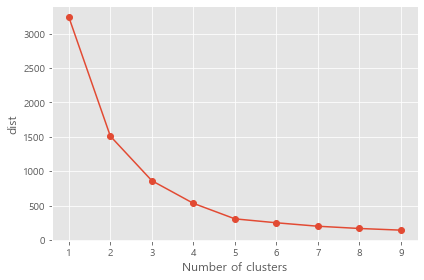

In [15]:
dist=[]
for i in range(1,10):
    km=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=0)
    km.fit(pca_data)
    dist.append(km.inertia_)
    
plt.plot(range(1,10), dist,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('dist')
plt.tight_layout()
plt.show()

## 2. Silhoutte 방법

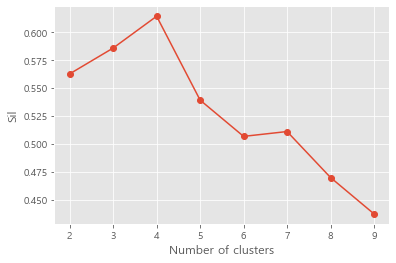

In [17]:
sil=[]
for i in range(2,10):
    km=KMeans(n_clusters=i,init='k-means++')
    pred=km.fit_predict(pca_data)
    sil.append(np.mean(silhouette_samples(pca_data,pred,metric='euclidean')))
    
plt.plot(range(2,10),sil,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sil')
plt.show()

#  군집분석(4개의 군집으로)

In [18]:
dist=[]
km=KMeans(n_clusters=4,init='k-means++',random_state=0)
clusters=km.fit(pca_data)
pca_data['cluster']=clusters.labels_

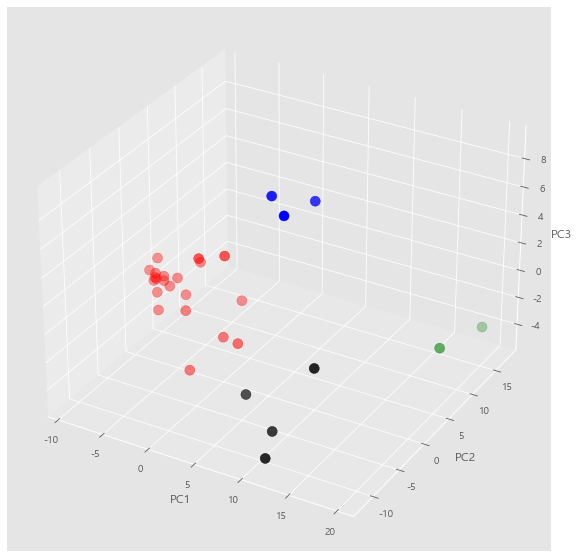

In [19]:
color=[]
for n in pca_data['cluster']:
    if n==0:
        color.append('red')
    elif n==1:
        color.append('green')
    elif n==2:
        color.append('black')
    else:
        color.append('blue')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data['PC1'], pca_data['PC2'], pca_data['PC3'], c=color, marker='o', s=100)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

## (0그룹 : 21개 지역), (1그룹 : 4개지역), (2그룹 : 2개지역), (3그룹 : 3개지역)

In [20]:
jisu['cluster']=pca_data['cluster']

In [21]:
jisu.groupby('cluster').count()

,사업용자동차,자전거및이륜차,보행자,교통약자,운전자,도로환경
cluster,,,,,,
0,21,21,21,21,21,21
1,2,2,2,2,2,2
2,4,4,4,4,4,4
3,3,3,3,3,3,3


## 그룹별 평균

### 그룹 0의 경우 평균 세부지표점수가 80점을 넘는 수치 기록
### 그룹 1(불당동, 성정2동)의 경우 자전거 및 이륜차, 운전자, 도로환경이 낮은 수치 기록
### 그룹 2(목천읍, 문성동, 직산읍, 중앙동)의 경우 사업용자동차, 교통약자, 도로환경이 낮은 수치 기록
### 그룹 3(부성1동, 부성2동, 신안동)의 경우 사업용자동차, 운전자, 도로환경이 낮은 수치 기록

In [22]:
jisu.groupby('cluster').mean()

,사업용자동차,자전거및이륜차,보행자,교통약자,운전자,도로환경
cluster,,,,,,
0,81.186325,86.843747,89.575133,86.802171,84.500303,82.128675
1,78.320957,67.724149,88.152136,83.244668,71.592449,68.939901
2,74.944853,85.181182,84.657688,77.477182,82.680701,69.791323
3,71.660546,86.001008,85.539590,86.217029,74.212857,75.557928
